Functional style transfer
============

Minimal reimplementation of <https://github.com/leongatys/PytorchNeuralStyleTransfer>
with PyTorch functional interface.

In [1]:
%pylab inline
import requests
import numpy as np
from StringIO import StringIO
from PIL import Image
from IPython import display
import hickle as hkl
import torch
from torch.autograd import Variable
import torch.nn.functional as F
from torch.optim import LBFGS
from torchvision import transforms
from torch.backends import cudnn
cudnn.benchmark = True

Populating the interactive namespace from numpy and matplotlib


In [3]:
style_url = 'https://github.com/leongatys/PytorchNeuralStyleTransfer/blob/master/Images/vangogh_starry_night.jpg?raw=true'
content_url = 'https://github.com/leongatys/PytorchNeuralStyleTransfer/blob/master/Images/Tuebingen_Neckarfront.jpg?raw=true'

In [4]:
def gram(input):
    b,c,h,w = input.size()
    F = input.view(b, c, h*w)
    G = torch.bmm(F, F.transpose(1,2))
    G.div_(h*w)
    return G


style_layers = [0, 5, 10, 17, 24]
content_layers = [19]


def vgg(inputs, params):
    '''VGG definition with style and content outputs.
    '''
    style, content = [], []
    def conv2d(x, params, name, stride=1, padding=0):
        return F.conv2d(x, params['%s.weight'%name], params['%s.bias'%name], stride, padding)
    
    def block(x, ids):
        for i in ids:
            x = F.relu(conv2d(x, params, 'features.%d' % i, 1, 1), inplace=True)
            if i in style_layers:
                style.append(gram(x))
            if i in content_layers:
                content.append(x)
        return F.max_pool2d(x, 2, 2)

    o = block(inputs, [0, 2])
    o = block(o, [5, 7])
    o = block(o, [10, 12, 14])
    o = block(o, [17, 19, 21])
    o = block(o, [24, 26, 28])
    return style, content

In [31]:
# pre and post processing for images
img_size = 512
tr_mean, tr_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
prep = transforms.Compose([transforms.Scale(img_size),
                           transforms.ToTensor(),
                           transforms.Normalize(tr_mean, tr_std),
                          ])
postpb = transforms.ToPILImage()

def postp(tensor): # to clip results in the range [0,1]
    mu = torch.Tensor(tr_mean).view(-1,1,1)
    sigma = torch.Tensor(tr_std).view(-1,1,1)
    img = postpb((tensor * sigma + mu).clamp(0, 1))
    return img

In [25]:
params = hkl.load('vgg16.hkl')

# convert numpy arrays to torch Variables
for k,v in params.items():
    params[k] = Variable(torch.from_numpy(v).cuda())

In [26]:
def load(url):
    response = requests.get(url)
    return Image.open(StringIO(response.content))

imgs = [load(style_url), load(content_url)]
imgs_torch = [Variable(prep(img).unsqueeze(0).cuda()) for img in imgs]
style_image, content_image = imgs_torch

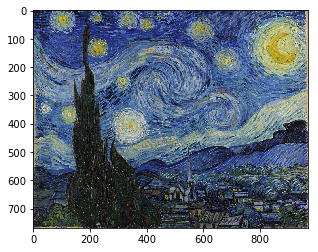

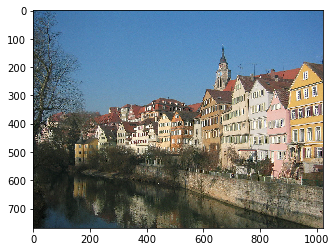

In [27]:
#display images
for img in imgs:
    imshow(img);show()

In [35]:
#these are good weights settings:
style_weights = [1e4/n**2 for n in [64,128,256,512,512]]
content_weights = [1e-4]

In [36]:
style_targets = vgg(style_image, params)[0]
content_targets = vgg(content_image, params)[1]

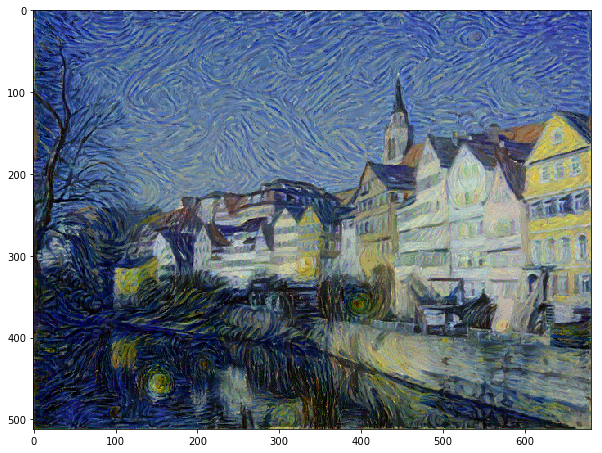

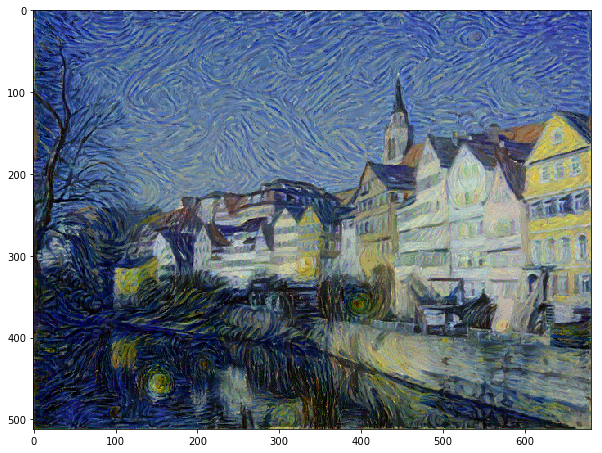

In [37]:
#run style transfer
max_iter = 500
show_iter = 50
opt_img = Variable(content_image.data.clone(), requires_grad=True)
optimizer = LBFGS([opt_img]);
n_iter=[0]

def mse_loss(x, y):
    return ((x.view(-1) - y.view(-1)) ** 2).mean()

while n_iter[0] <= max_iter:

    def closure():
        optimizer.zero_grad()
        style, content = vgg(opt_img, params)
        style_loss = sum(alpha * mse_loss(u, v)
                         for alpha, u, v in zip(style_weights, style, style_targets))
        content_loss = sum(beta * mse_loss(u, v)
                           for beta, u, v in zip(content_weights, content, content_targets))
        loss = style_loss + content_loss
        loss.backward()
        n_iter[0]+=1
        #print loss
        if n_iter[0]%show_iter == (show_iter-1):
            print('Iteration: %d, loss: %f'%(n_iter[0]+1, loss.data[0]))

        return loss
    
    optimizer.step(closure)
    
    # display result at each step
    out_img = postp(opt_img.data[0].cpu().squeeze())
    display.clear_output(wait=True)
    imshow(out_img)
    gcf().set_size_inches(10,10)
    display.display(gcf())